### Final end-to-end procedure

We will now run the full conformal procedure, randomly shuffling the data into a calibration and test set, before using the best lambda found on calibration to evaluate using hierarchical loss on test. Lets see how far the test loss diverges from the best lambda's loss (which we know is within our threshold of sampling proteins with at least the same superfamily).

In [2]:
from protein_conformal.util import get_sims_labels, get_thresh_hierarchical, get_hierarchical_loss
import numpy as np
near_ids = np.load('uniprot_ec_test_v_lookup.npy', allow_pickle=True)

sims, _ = get_sims_labels(near_ids, partial=False)
sims = np.asarray(sims)

# Normalize data using min-max scaling (we assume we don't have )
min_sim, max_sim = min(sims), max(sims)
min_row, max_row = [], []
for query in near_ids:
    query['Norm_S_i'] = (query['S_i'] - min_sim) / (max_sim - min_sim) # normalize each row of S_i
    min_row.append(min(query['Norm_S_i'])) 
    max_row.append(max(query['Norm_S_i']))

    # Now we cumsum the normalized S_i
    query['Sum_Norm_S_i'] = np.cumsum(query['Norm_S_i'])
sims_norm = (sims - min(sims)) / (max(sims) - min(sims))

# Define lambda linspace, NOTE: for now we want to play around with it so we keep it here, can move it to the get_thresh_hierarchical function later.
x = np.linspace(min(min_row)*near_ids[0]['S_i'].shape[0], max(max_row)*near_ids[0]['S_i'].shape[0], near_ids[0]['S_i'].shape[0])

num_trials = 10
alpha = 1 # max avg. loss we want (on average, each protein retrieved is at most divergent at the family level only)
n_calib = 300 # NOTE: 300 calib, 100 test for now.
for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(near_ids)
    cal_data = near_ids[:n_calib]
    test_data = near_ids[n_calib:]
    lhat, _ = get_thresh_hierarchical(cal_data, x, alpha)

    test_loss = get_hierarchical_loss(test_data, lhat)

    print(f'Trial {trial+1}: Lambda: {lhat:.2f}, Test loss: {test_loss:.2f}')
    
    #error, fraction_inexact, error_partial, fraction_partial = validate_lhat(test_data, lhat)
    #print(f'Trial {trial+1}: Ex&!Id/Ex: {error:.2f}, In/Id: {fraction_inexact:.2f}, Pa&!Id/Pa: {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f}')


worst case loss: 7.9095215537659875
Loss threshold: 0.9769682614874468
Best lambda: 4.000136551394531
Loss of best lambda: 0.9625
Trial 1: Lambda: 4.00, Test loss: 0.97
worst case loss: 7.9095215537659875
Loss threshold: 0.9769682614874468
Best lambda: 4.000136551394531
Loss of best lambda: 0.9533333333333334
Trial 2: Lambda: 4.00, Test loss: 0.99
worst case loss: 7.9095215537659875
Loss threshold: 0.9769682614874468
Best lambda: 3.0001024135458985
Loss of best lambda: 0.9766666666666667
Trial 3: Lambda: 3.00, Test loss: 0.83
worst case loss: 7.9095215537659875
Loss threshold: 0.9769682614874468
Best lambda: 4.000136551394531
Loss of best lambda: 0.9416666666666667
Trial 4: Lambda: 4.00, Test loss: 1.02
worst case loss: 7.9095215537659875
Loss threshold: 0.9769682614874468
Best lambda: 3.0001024135458985
Loss of best lambda: 0.9422222222222223
Trial 5: Lambda: 3.00, Test loss: 0.90
worst case loss: 7.9095215537659875
Loss threshold: 0.9769682614874468
Best lambda: 4.000136551394531
Los

In [3]:
num_trials = 10
alpha = 2 # max avg. loss we want (on average, each protein retrieved is at most divergent at the family and superfamily level only)
n_calib = 300 # NOTE: 300 calib, 100 test for now.
for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(near_ids)
    cal_data = near_ids[:n_calib]
    test_data = near_ids[n_calib:]
    lhat, _ = get_thresh_hierarchical(cal_data, x, alpha)

    test_loss = get_hierarchical_loss(test_data, lhat)

    print(f'Trial {trial+1}: Lambda: {lhat:.2f}, Test loss: {test_loss:.2f}')
    
    #error, fraction_inexact, error_partial, fraction_partial = validate_lhat(test_data, lhat)
    #print(f'Trial {trial+1}: Ex&!Id/Ex: {error:.2f}, In/Id: {fraction_inexact:.2f}, Pa&!Id/Pa: {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f}')


worst case loss: 7.9095215537659875
Loss threshold: 1.98030159482078
Best lambda: 66.00225309800976
Loss of best lambda: 1.9739614907736367
Trial 1: Lambda: 66.00, Test loss: 1.76
worst case loss: 7.9095215537659875
Loss threshold: 1.98030159482078
Best lambda: 65.00221896016113
Loss of best lambda: 1.9786618340121587
Trial 2: Lambda: 65.00, Test loss: 1.73
worst case loss: 7.9095215537659875
Loss threshold: 1.98030159482078
Best lambda: 72.00245792510157
Loss of best lambda: 1.9751631143079225
Trial 3: Lambda: 72.00, Test loss: 1.88
worst case loss: 7.9095215537659875
Loss threshold: 1.98030159482078
Best lambda: 83.00283344143652
Loss of best lambda: 1.9787295320528604
Trial 4: Lambda: 83.00, Test loss: 2.08
worst case loss: 7.9095215537659875
Loss threshold: 1.98030159482078
Best lambda: 72.00245792510157
Loss of best lambda: 1.9778854598102604
Trial 5: Lambda: 72.00, Test loss: 1.88
worst case loss: 7.9095215537659875
Loss threshold: 1.98030159482078
Best lambda: 81.00276516573926


In [4]:
x = np.linspace(0, 100, 100) # max family size is ~100, assuming all retrieved proteins are max prob of 1

loss = []
for l in x:
    loss.append(get_hierarchical_loss(near_ids, l))



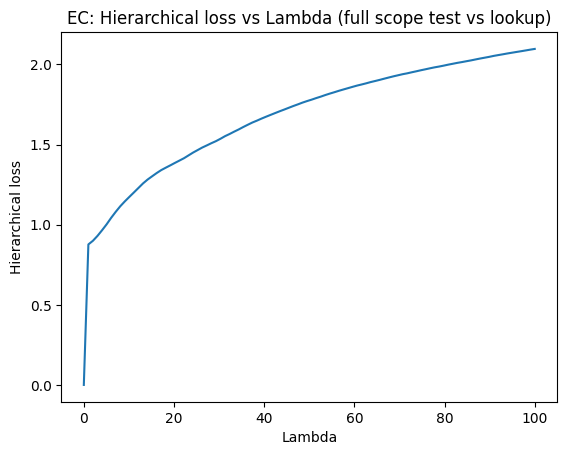

In [6]:
# plot loss vs lambda
import matplotlib.pyplot as plt
plt.plot(x, loss)
plt.xlabel('Lambda')
plt.ylabel('Hierarchical loss')
plt.title('EC: Hierarchical loss vs Lambda (full scope test vs lookup)')
plt.show()


### Try max hierarchical loss
Taking the max over the set of retrieved proteins within our similarity threshold may be better, as it increases monotonically.

In [7]:
from util import get_sims_labels, get_hierarchical_max_loss, get_thresh_max_hierarchical
import numpy as np
near_ids = np.load('uniprot_ec_test_v_lookup.npy', allow_pickle=True)

sims, _ = get_sims_labels(near_ids, partial=False)

x = np.linspace(min(sims), max(sims), 1000)

min(x), max(x)

(0.9992204904556274, 1.0000001192092896)

In [8]:
loss = []
for l in reversed(x):
    loss.append(get_hierarchical_max_loss(near_ids, l))



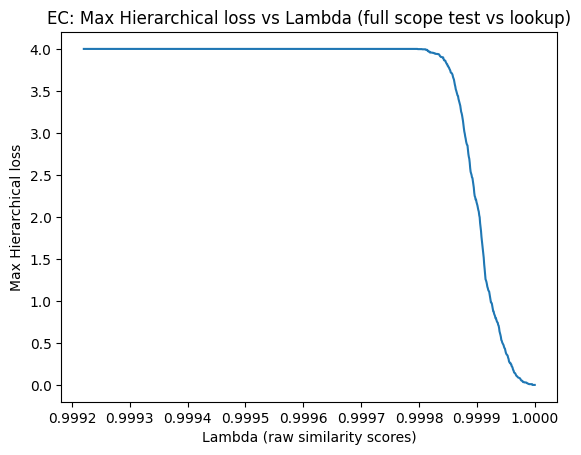

In [9]:
import matplotlib.pyplot as plt
plt.plot(x, loss[::-1])
plt.xlabel('Lambda (raw similarity scores)')
plt.ylabel('Max Hierarchical loss')
plt.title('EC: Max Hierarchical loss vs Lambda (full scope test vs lookup)')
plt.show()


In [10]:
num_trials = 10
alpha = 1 # max avg. loss we want (on average, each protein retrieved is at most divergent at the family level only)
n_calib = 300 # NOTE: 300 calib, 100 test for now.
for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(near_ids)
    cal_data = near_ids[:n_calib]
    test_data = near_ids[n_calib:]
    lhat, _ = get_thresh_max_hierarchical(cal_data, x, alpha)

    test_loss = get_hierarchical_max_loss(test_data, lhat)

    print(f'Trial {trial+1}: Lambda: {lhat:.2f}, Test loss: {test_loss:.2f}')
    
    #error, fraction_inexact, error_partial, fraction_partial = validate_lhat(test_data, lhat)
    #print(f'Trial {trial+1}: Ex&!Id/Ex: {error:.2f}, In/Id: {fraction_inexact:.2f}, Pa&!Id/Pa: {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f}')


worst case loss: 4
Loss threshold: 0.99
Best lambda: 0.999926760747984
Loss of best lambda: 0.99
Trial 1: Lambda: 1.00, Test loss: 0.83
worst case loss: 4
Loss threshold: 0.99
Best lambda: 0.9999275411571469
Loss of best lambda: 0.95
Trial 2: Lambda: 1.00, Test loss: 0.80
worst case loss: 4
Loss threshold: 0.99
Best lambda: 0.9999244195204955
Loss of best lambda: 0.9766666666666667
Trial 3: Lambda: 1.00, Test loss: 0.99
worst case loss: 4
Loss threshold: 0.99
Best lambda: 0.9999244195204955
Loss of best lambda: 0.99
Trial 4: Lambda: 1.00, Test loss: 0.96
worst case loss: 4
Loss threshold: 0.99
Best lambda: 0.9999259803388212
Loss of best lambda: 0.98
Trial 5: Lambda: 1.00, Test loss: 0.94
worst case loss: 4
Loss threshold: 0.99
Best lambda: 0.9999244195204955
Loss of best lambda: 0.9733333333333334
Trial 6: Lambda: 1.00, Test loss: 1.00
worst case loss: 4
Loss threshold: 0.99
Best lambda: 0.9999259803388212
Loss of best lambda: 0.9866666666666667
Trial 7: Lambda: 1.00, Test loss: 0.93
